<a href="https://colab.research.google.com/github/AbhinavKumar0000/Machine_learning_practice/blob/main/Dissertation_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing necessary Libraries



In [1]:
import os
import shutil
import random
import zipfile
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as T
from tqdm import tqdm

# Downloading Dataset

In [2]:
DATASET_URL = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
DATA_DIR = "/content/EuroSAT_data"

#Downloading the dataset using wget
!wget -q -O EuroSAT.zip {DATASET_URL}

#Unziping the file
with zipfile.ZipFile("EuroSAT.zip", 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)


SOURCE_DIR = os.path.join(DATA_DIR, "2750")

print(f"Dataset downloaded and unzipped to {SOURCE_DIR}")

Dataset downloaded and unzipped to /content/EuroSAT_data/2750


# Dividing data into test and train set
85% training set
15% testing set

In [3]:
SPLIT_DIR = "/content/EuroSAT_split"
TRAIN_PATH = os.path.join(SPLIT_DIR, "train")
VAL_PATH = os.path.join(SPLIT_DIR, "val")

CLASSES = [d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, d))]

if os.path.exists(SPLIT_DIR):
    shutil.rmtree(SPLIT_DIR)
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(VAL_PATH, exist_ok=True)

for class_name in CLASSES:
    os.makedirs(os.path.join(TRAIN_PATH, class_name), exist_ok=True)
    os.makedirs(os.path.join(VAL_PATH, class_name), exist_ok=True)

    class_images = glob(os.path.join(SOURCE_DIR, class_name, "*.jpg"))
    random.shuffle(class_images)

    split_idx = int(len(class_images) * 0.85)
    train_images = class_images[:split_idx]
    val_images = class_images[split_idx:]

    for img_path in train_images:
        shutil.copy(img_path, os.path.join(TRAIN_PATH, class_name))
    for img_path in val_images:
        shutil.copy(img_path, os.path.join(VAL_PATH, class_name))

#Transforming dataset

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ENCODER = 'mobilenet_v2'
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
NUM_EPOCHS = 15
IMAGE_SIZE = 64
NUM_CLASSES = len(CLASSES)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=transform)
val_dataset = datasets.ImageFolder(root=VAL_PATH, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


#Checking GPU

In [5]:
!nvidia-smi

Sat Aug 30 09:01:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Defining model and other parameters

In [6]:
model = models.mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')
model.classifier[1] = nn.Linear(model.last_channel, NUM_CLASSES)
model.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 59.9MB/s]
/tmp/ipython-input-4242662032.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


#Training the model

In [7]:
best_accuracy = 0.0
model_save_path = '/content/best_eurosat_model.pth'

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    model.train()
    loop = tqdm(train_loader, desc="Training")

    for images, labels in loop:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loop.set_postfix(loss=loss.item())

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f"New best model saved with Accuracy: {best_accuracy:.2f}%")



Epoch 1/15


Training:   0%|          | 0/359 [00:00<?, ?it/s]/tmp/ipython-input-1782950657.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 359/359 [00:28<00:00, 12.42it/s, loss=0.197]


Validation Accuracy: 95.06%
New best model saved with Accuracy: 95.06%

Epoch 2/15


Training: 100%|██████████| 359/359 [00:20<00:00, 17.77it/s, loss=0.0426]


Validation Accuracy: 96.81%
New best model saved with Accuracy: 96.81%

Epoch 3/15


Training: 100%|██████████| 359/359 [00:18<00:00, 19.28it/s, loss=0.202]


Validation Accuracy: 96.37%

Epoch 4/15


Training: 100%|██████████| 359/359 [00:20<00:00, 17.88it/s, loss=0.0323]


Validation Accuracy: 96.67%

Epoch 5/15


Training: 100%|██████████| 359/359 [00:20<00:00, 17.10it/s, loss=0.0762]


Validation Accuracy: 93.83%

Epoch 6/15


Training: 100%|██████████| 359/359 [00:19<00:00, 18.15it/s, loss=0.218]


Validation Accuracy: 96.59%

Epoch 7/15


Training: 100%|██████████| 359/359 [00:19<00:00, 18.73it/s, loss=0.0343]


Validation Accuracy: 97.46%
New best model saved with Accuracy: 97.46%

Epoch 8/15


Training: 100%|██████████| 359/359 [00:20<00:00, 17.83it/s, loss=0.0382]


Validation Accuracy: 97.36%

Epoch 9/15


Training: 100%|██████████| 359/359 [00:19<00:00, 17.97it/s, loss=0.00532]


Validation Accuracy: 97.48%
New best model saved with Accuracy: 97.48%

Epoch 10/15


Training: 100%|██████████| 359/359 [00:19<00:00, 18.84it/s, loss=0.497]


Validation Accuracy: 96.81%

Epoch 11/15


Training: 100%|██████████| 359/359 [00:19<00:00, 18.71it/s, loss=0.00542]


Validation Accuracy: 97.36%

Epoch 12/15


Training: 100%|██████████| 359/359 [00:20<00:00, 17.88it/s, loss=0.0683]


Validation Accuracy: 97.11%

Epoch 13/15


Training: 100%|██████████| 359/359 [00:20<00:00, 17.95it/s, loss=0.0671]


Validation Accuracy: 97.31%

Epoch 14/15


Training: 100%|██████████| 359/359 [00:18<00:00, 19.07it/s, loss=0.00983]


Validation Accuracy: 96.37%

Epoch 15/15


Training: 100%|██████████| 359/359 [00:19<00:00, 18.44it/s, loss=0.0156]


Validation Accuracy: 97.14%


#Generating confusion matrix

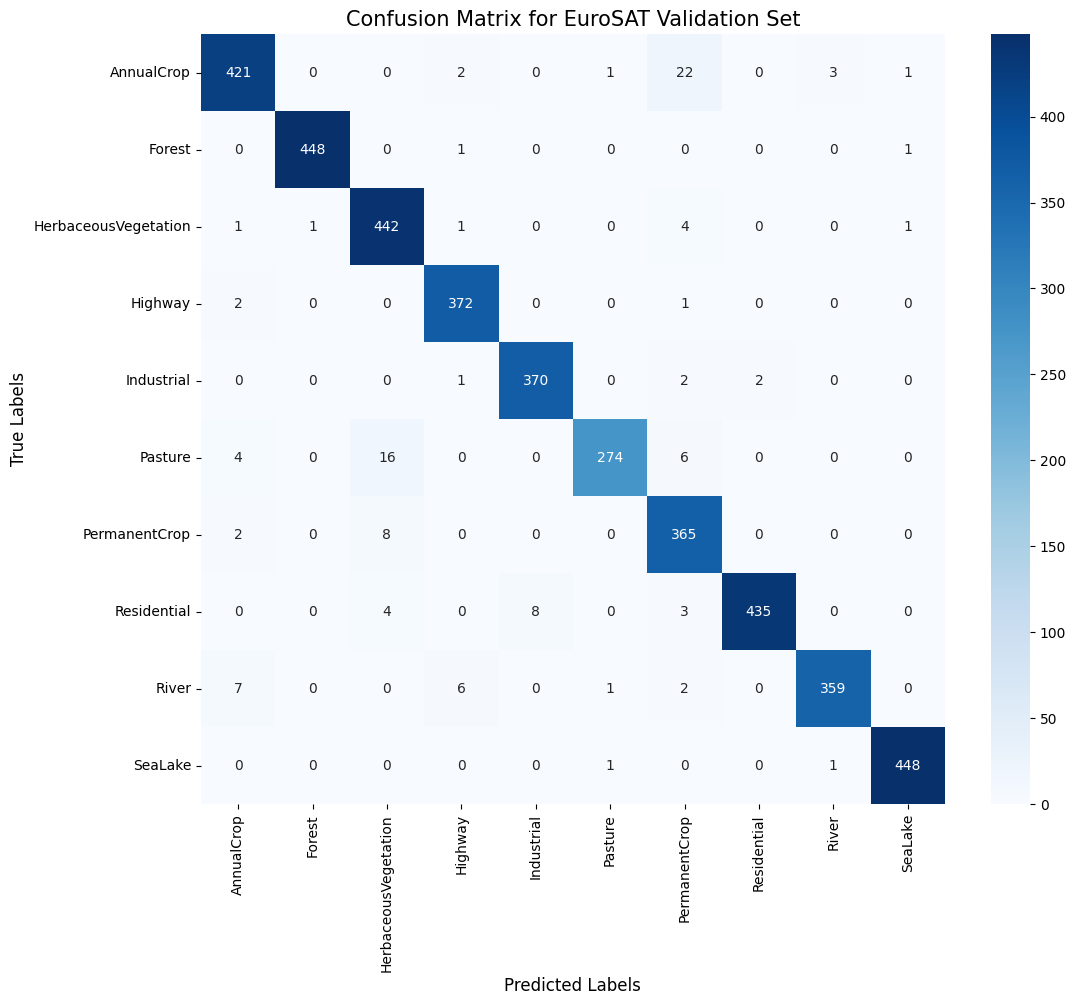

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def get_all_preds(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

y_pred, y_true = get_all_preds(model, val_loader)
class_names = val_dataset.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for EuroSAT Validation Set', fontsize=15)
plt.show()

#Generating classification report

In [12]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

Classification Report:

                      precision    recall  f1-score   support

          AnnualCrop       0.96      0.94      0.95       450
              Forest       1.00      1.00      1.00       450
HerbaceousVegetation       0.94      0.98      0.96       450
             Highway       0.97      0.99      0.98       375
          Industrial       0.98      0.99      0.98       375
             Pasture       0.99      0.91      0.95       300
       PermanentCrop       0.90      0.97      0.94       375
         Residential       1.00      0.97      0.98       450
               River       0.99      0.96      0.97       375
             SeaLake       0.99      1.00      0.99       450

            accuracy                           0.97      4050
           macro avg       0.97      0.97      0.97      4050
        weighted avg       0.97      0.97      0.97      4050



# Visualize 10 random misclassified images

116 misclassified images out of 4050 total images.


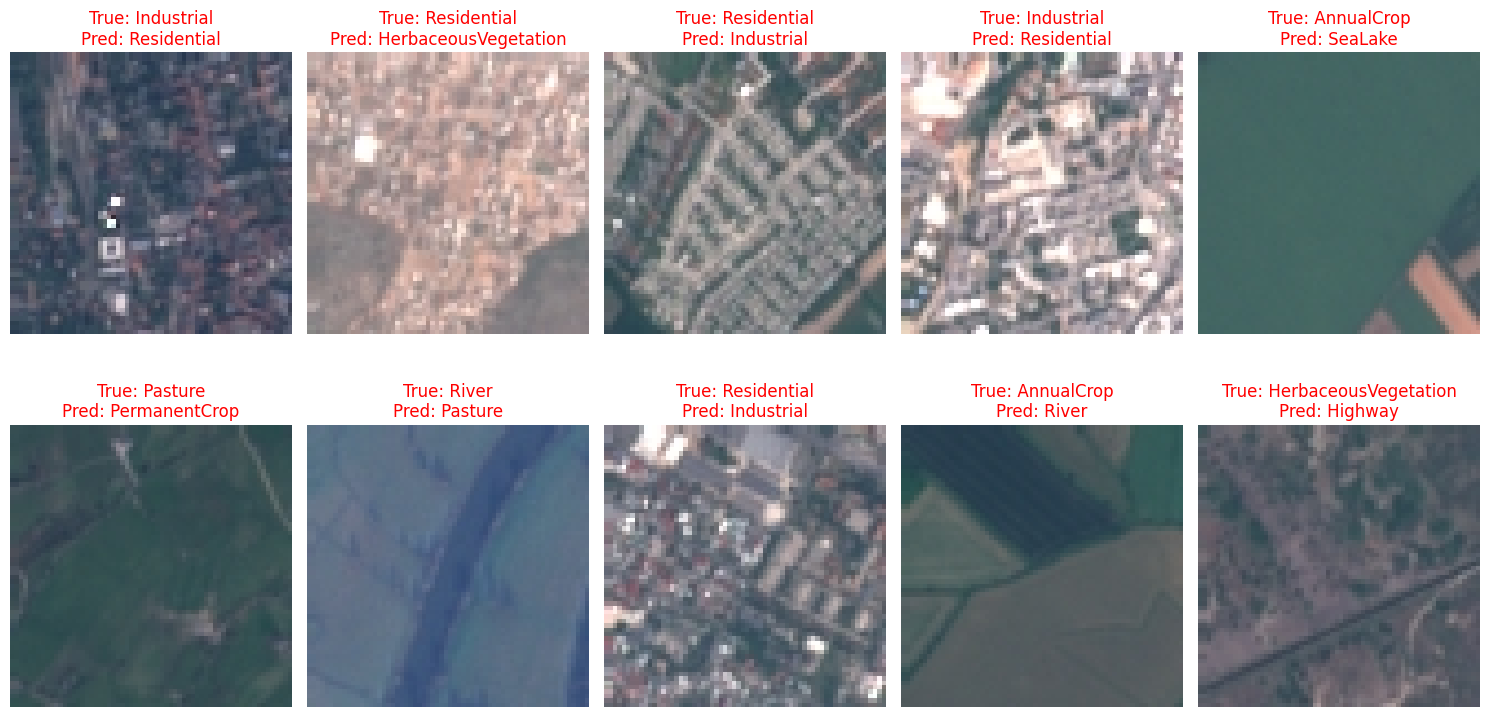

In [14]:
from PIL import Image

misclassified_indices = np.where(y_pred != y_true)[0]
print(f"{len(misclassified_indices)} misclassified images out of {len(y_true)} total images.")

def visualize_misclassified(dataset, misclassified_indices, preds, true_labels, num_samples=10):
    class_names = dataset.classes
    sample_indices = np.random.choice(misclassified_indices, size=min(num_samples, len(misclassified_indices)), replace=False)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(sample_indices):
        img_path, _ = dataset.samples[idx]
        image_pil = Image.open(img_path).convert("RGB")

        true_label = class_names[true_labels[idx]]
        pred_label = class_names[preds[idx]]

        plt.subplot(2, 5, i + 1)
        plt.imshow(image_pil)
        plt.title(f"True: {true_label}\nPred: {pred_label}", color="red")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_misclassified(val_dataset, misclassified_indices, y_pred, y_true, num_samples=10)